In [1]:
import os
import shutil

import re
import time
import pandas as pd

import pprint

#from gensim.models import Phrases
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
# NLTK Stop words

import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across'])

NewCorpus = pd.read_excel('CorpusBeta.xlsx',header=0)

NewCorpus['Titles & Keywords'] = NewCorpus['Title'] +' '+ NewCorpus['Author Keywords'] +' '+ NewCorpus['Abstract'].str.split('©').str[0] #+' '+ NewCorpus['Year'].astype(str)
len(NewCorpus)

2014

In [2]:
import nltk
from sklearn.feature_extraction import text
stop_words = list(text.ENGLISH_STOP_WORDS)
import string

#Words not must be included in the analysis
removed = ['machine','translation','automatic','mt']
#Define the function to remove the punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = str(text).replace(punctuation, ' ')
    return text

#Lemmatizaion of the keywords
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(str(text))]

#merge words of a list into string 
def ListToString(lista):
    text = ''
    for word in lista:
        text += ' '+word
    return text

#Replace Abbreviation
def replace_Abbreviation(text):
    text = str(text).replace('smt', 'statistical')
    text = str(text).replace('nmt', 'neural')
    text = str(text).replace('rbmt','rule based')
    text = str(text).replace('hmt','Hybrid based')
    text = str(text).replace('dmt','direct based')
    text = str(text).replace('tbmt','transfer based')
    text = str(text).replace('cbmt','corpus based')
    text = str(text).replace('ebmt','example based')
    return text

#Apply Remove Punctuations
NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].apply(remove_punctuations)
#Remove Stop words:
NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))
#Lowercase Author Keywords
NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].str.lower()
#Remove All words that could mess our classification
NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in removed))
NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].apply(replace_Abbreviation)
#Apply the function lemmatization
NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].apply(lemmatize_text)
NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].apply(ListToString)
NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].str.replace('\d+', '')
NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].str.replace('  ', ' ')
#NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].str.split('©').str[0]
NewCorpus['Titles & Keywords'][0]

C:\Users\HP\AppData\Local\Temp/ipykernel_13096/2709741641.py:52: FutureWarning: The default value of regex will change from True to False in a future version.
  NewCorpus['Titles & Keywords'] = NewCorpus['Titles & Keywords'].str.replace('\d+', '')


' matching graph method extracting parallel information comparable corpus and arabic language comparable corpus english generative model information extraction natural language processing parallel fragment persian statistical comparable corpus valuable alternative expensive parallel corpus they comprise informative parallel fragment useful resource different natural language processing task in work generative model proposed efficient extraction parallel fragment pair comparable document the core proposed model graph called matching graph the ability matching graph trained small initial seed make proper model language pair suffering scarce resource problem experiment matching graph performs significantly better recently publishedmodels according experiment english persian arabic persian language pair extracted parallel fragment used instead parallel data training statistical system result reveal extracted fragment best case able retrieve information statistical trained parallel corpus m

In [3]:
# Convert to list
df = NewCorpus['Titles & Keywords'].values.tolist()

df = [re.sub('\S*@\S*\s?', '', sent) for sent in df]

# Remove new line characters
df = [re.sub('\s+', ' ', sent) for sent in df]

# Remove distracting single quotes
df = [re.sub("\'", "", sent) for sent in df]

print(df[:1])

df = [re.sub("-", " ", sent) for sent in df]
df = [re.sub(":", "", sent) for sent in df]

print(df[:2])

[' matching graph method extracting parallel information comparable corpus and arabic language comparable corpus english generative model information extraction natural language processing parallel fragment persian statistical comparable corpus valuable alternative expensive parallel corpus they comprise informative parallel fragment useful resource different natural language processing task in work generative model proposed efficient extraction parallel fragment pair comparable document the core proposed model graph called matching graph the ability matching graph trained small initial seed make proper model language pair suffering scarce resource problem experiment matching graph performs significantly better recently publishedmodels according experiment english persian arabic persian language pair extracted parallel fragment used instead parallel data training statistical system result reveal extracted fragment best case able retrieve information statistical trained parallel corpus 

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

df_words = list(sent_to_words(df))
len(df_words)

2014

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df_words, min_count=5, threshold=10)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [6]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NN', 'NNP', 'NNS', 'NNPS']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.tag_ in allowed_postags])
    return texts_out

# Remove Stop Words

data_words_nostops = remove_stopwords(df_words)

# Form Bigrams

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
#_core_web_sm
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NN', 'NNP', 'NNS', 'NNPS'])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [7]:
# Create Corpus
texts = data_lemmatized
#texts[:5]

In [8]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
#corpus[:2]

In [10]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

ValueError: cannot compute LDA over an empty collection (no terms)

In [9]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

NameError: name 'lda_model' is not defined

the number of topics is : 6


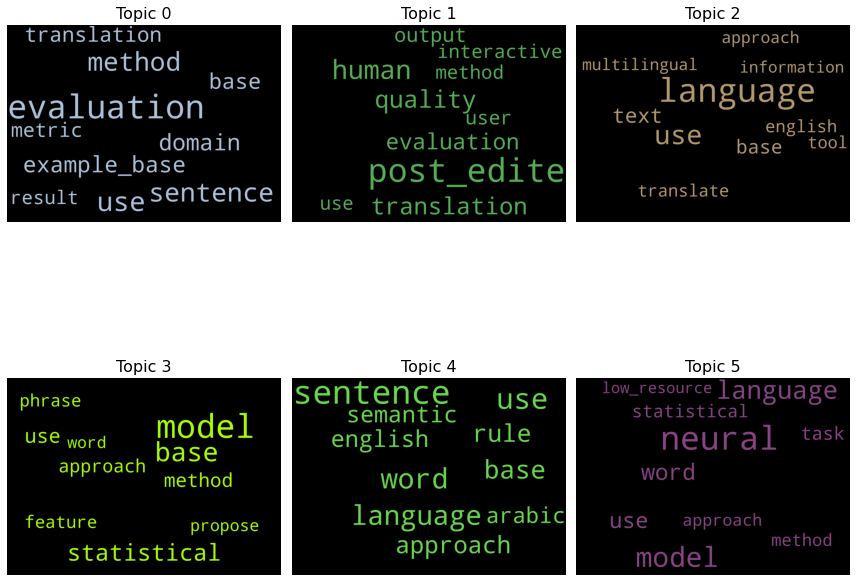

In [11]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

#cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=20,formatted=False)
print('the number of topics is : '+str(len(topics)))
fig, axes = plt.subplots(2, 3, figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [12]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3249783208124079


In [37]:
from operator import itemgetter

corpus_transformed_s = lda_model[corpus]
#corpus_transformed = ldan[0][corpusn[0]]
#len(corpus_transformed)
[max(corpus_transformed_s[0], key=itemgetter(1))]

[[(1, 0.16444655),
  (2, 0.044505004),
  (3, 0.60463905),
  (4, 0.06715867),
  (5, 0.11762991)]]

In [29]:
corpo = []
for i in range(len(corpus_transformed_s)):
    if len(str(len(corpus_transformed_s[i]))) > 1:
        corpo.append([max(corpus_transformed_s[i], key=itemgetter(1))])
    else:
        corpo.append(corpus_transformed_s[i])
NewCorpus['Topic'] = corpo
NewCorpus

,Title,Abstract,Author Keywords,Link,Year,Cited by,Page start,Page end,Page count,DOI,Authors,Document Type,Source,From-->Too,Method Used,is it a survey?,Titles & Keywords,Topic
0,"Matching graph, a method for extracting parall...",Comparable corpora are valuable alternatives f...,And Arabic languages; Comparable corpora; Engl...,https://www.scopus.com/inward/record.uri?eid=2...,2019,NaN,NaN,NaN,1,10.1145/3329713,"Bakhshaei S., Safabakhsh R., Khadivi S.",Article,Scopus,"['persian', 'arabic', 'english']",['statistical'],[],matching graph method extracting parallel inf...,"([(1, 0.16646476), (2, 0.036625676), (3, 0.602..."
1,Machine translation errors: English and Iraqi ...,Errors in machine translations of English-Iraq...,Arabic; English; Error analysis; Evaluation; S...,https://www.scopus.com/inward/record.uri?eid=2...,2011,1.0,NaN,NaN,1,10.1145/1929908.1929910,"Condon S., Parvaz D., Aberdeen J., Doran C., F...",Article,Scopus,"['arabic', 'english']",['statistical'],[],error english iraqi arabic arabic english err...,"([(1, 0.51835835), (4, 0.4737218)], [(5, [4]),..."
2,An automatic and a machine-assisted method to ...,Two different methods of corpus cleaning are p...,Bilingual corpus cleaning; Statistical machine...,https://www.scopus.com/inward/record.uri?eid=2...,2019,NaN,NaN,NaN,1,10.1145/3342351,"Srivastava J., Sanyal S., Srivastava A.K.",Article,Scopus,"['hindi', 'english']",['statistical'],[],an assisted method clean bilingual corpus bil...,"([(0, 0.21934062), (2, 0.3266841), (3, 0.44836..."
3,Combining MEDLINE and publisher data to create...,Background: Most of the institutional and rese...,Biomedical domain; Multilingual corpus generat...,https://www.scopus.com/inward/record.uri?eid=2...,2013,14.0,NaN,NaN,1,10.1186/1471-2105-14-146,"Jimeno Yepes A., Prieur-Gaston É., Névéol A.",Article,Scopus,"['spanish', 'french', 'english']",['statistical'],[],combining medline publisher data create paral...,"([(0, 0.13629128), (2, 0.7820296), (3, 0.07773..."
4,Syntax-based Chinese-Vietnamese tree-to-tree s...,"Because of the scarcity of bilingual corpora, ...",Chinese-Vietnamese; Linguistic features; Pruni...,https://www.scopus.com/inward/record.uri?eid=2...,2019,1.0,NaN,NaN,1,10.1145/3314938,"Gao S., Huang J., Xue M., Yu Z., Wang Z., Zhan...",Article,Scopus,"['vietnamese', 'chinese']",['statistical'],[],syntax based chinese vietnamese tree tree sta...,"([(3, 0.8365124), (5, 0.15463902)], [(18, [3, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,Machine translation architecture based on micr...,This paper surveys current approaches of multi...,Machine translation; Micro-engine pipeline; Mu...,https://www.scopus.com/inward/record.uri?eid=2...,2004,NaN,651,658,8,NaN,Liu Q.,Article,Scopus,"['chinese', 'english']",[],[],architecture based micro engine pipeline micr...,"([(2, 0.78374237), (3, 0.20333147)], [(12, [2,..."
2010,Uyghur-Chinese translation disambiguation meth...,This thesis studies the disambiguation method ...,Knowledge automatic-acquisition; Uyghur-chines...,https://www.scopus.com/inward/record.uri?eid=2...,2015,NaN,NaN,NaN,6,NaN,"Ge R., Yong Y., Chun X.",Article,Scopus,"['uyghur', 'chinese']",[],[],uyghur chinese disambiguation method research...,"([(0, 0.24717312), (3, 0.3719004), (4, 0.34207..."
2011,Application and analysis of string-similarity-...,To help developing a localization-oriented exa...,Correlation; Linear regression; Machine transl...,https://www.scopus.com/inward/record.uri?eid=2...,2004,NaN,1258,1265,8,NaN,"Yao J.-M., Zhou M., Zhao T.-J., Li S.",Article,Scopus,[],[],[],application analysis string similarity based ...,"([(0, 0.76314896), (3, 0.16921008), (4, 0.0592..."
2012,A comparative study on applying hierarchical p...,To set an appropriate goal of SMT research for...,Hierarchical phrase-based translation; SMT; Th...,https://www.scopus.com/inward/record.uri?eid=2...,2012,1.0,126,133,8,10.1109/KICSS.2012.23,"Luekhong P., Sukhauta R., Porkaew P., Ruangraj...",Confere

In [27]:
for corp in corpus_transformed_s:
    if (int(str(len(corp)))) > 1:
        corpo.append([max(corp, key=itemgetter(1))])
    else:
        corpo.append(corp)
NewCorpus['Topic'] = corpo
NewCorpus

TypeError: '>' not supported between instances of 'tuple' and 'int'

In [13]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [14]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 25
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
print(str(len(corpus_sets)))

2


In [ ]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=2064)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results1.csv', index=False)
    pbar.close()

 65%|██████▌   | 1346/2064 [21:31:49<443:54:20, 2225.71s/it] 

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

C:\Users\HP\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis


# Visualize the topics
pyLDAvis.enable_notebook()
#LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#LDAvis_prepared

lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)
lda_viz

C:\Users\HP\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'ldamodel' is not defined

In [ ]:
###### import gensim.models.wrappers.ldamallet as ldamallet
#from gensim.models.wrappers import LdaMallet

import os
#from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel

os.environ['MALLET_HOME'] = "C:\\Users\\HP\\Desktop\\Equipe-ILC\\Automatisation\\LdaMallet\\mallet-2.0.8"

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = "C:\\Users\\HP\\Desktop\\Equipe-ILC\\Automatisation\\LdaMallet\\mallet-2.0.8\\bin\\mallet" # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit=30, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    i = 0
    for num_topics in range(start, limit, step):
        print('iteration : '+str(i)+' when the number of topics is : '+str(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        i+=1
    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=2)

In [ ]:
import matplotlib.pyplot as plt
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()